Creating treemap visualizations of clusters of variant spellings. 

Uses clusterings computed in `clustering.ipynb`.

In [1]:
import pickle
import squarify
from matplotlib import pyplot as plt

with open('clusters.pickle', 'rb') as f:
    clusters = pickle.load(f)

ad = clusters['adderall']
ad = list(ad.items())
ad

[('aderall', 16),
 ('adderral', 9),
 ('adderrall', 8),
 ('adderoll', 6),
 ('adderol', 17),
 ('adderall', 73),
 ('adderal', 46),
 ('aderal', 10)]

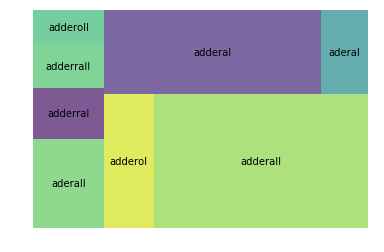

In [2]:
plt.axis('off')
forms, counts = zip(*ad)

squarify.plot(
    sizes=counts,
    label=forms,
    alpha=.7,
)

In [15]:
# Mostly a copy-paste job of squarify.plot's source. I needed to hack on a few
# details that weren't exposed in the API (kwargs for label text)

def squarifyplot(sizes, norm_x=100, norm_y=100,
         color=None, label=None, value=None,
                 labelfont=None,
         ax=None, labelsize=10, **kwargs):

    """
    Plotting with Matplotlib.

    Parameters
    ----------
    sizes: input for squarify
    norm_x, norm_y: x and y values for normalization
    color: color string or list-like (see Matplotlib documentation for details)
    label: list-like used as label text
    value: list-like used as value text (in most cases identical with sizes argument)
    ax: Matplotlib Axes instance
    kwargs: dict, keyword arguments passed to matplotlib.Axes.bar

    Returns
    -------
    axes: Matplotlib Axes
    """

    import matplotlib.pyplot as plt

    if ax is None:
        ax = plt.gca()

    if color is None:
        import matplotlib.cm
        import random
        cmap = matplotlib.cm.get_cmap()
        color = [cmap(random.random()) for i in range(len(sizes))]

    normed = squarify.normalize_sizes(sizes, norm_x, norm_y)
    rects = squarify.squarify(normed, 0, 0, norm_x, norm_y)

    x = [rect['x'] for rect in rects]
    y = [rect['y'] for rect in rects]
    dx = [rect['dx'] for rect in rects]
    dy = [rect['dy'] for rect in rects]

    ax.bar(x, dy, width=dx, bottom=y, color=color,
       label=label, align='edge', **kwargs)

    if not value is None:
        va = 'center' if label is None else 'top'

        for v, r in zip(value, rects):
            x, y, dx, dy = r['x'], r['y'], r['dx'], r['dy']
            ax.text(x + dx / 2, y + dy / 2, v, va=va, ha='center', fontsize=labelsize)

    if not label is None:
        va = 'center' if value is None else 'bottom'
        for l, r in zip(label, rects):
            x, y, dx, dy = r['x'], r['y'], r['dx'], r['dy']
            ax.text(x + dx / 2, y + dy / 2, l, va=va, ha='center', fontsize=labelsize,
                   fontname=labelfont)

    ax.set_xlim(0, norm_x)
    ax.set_ylim(0, norm_y)
    return ax 

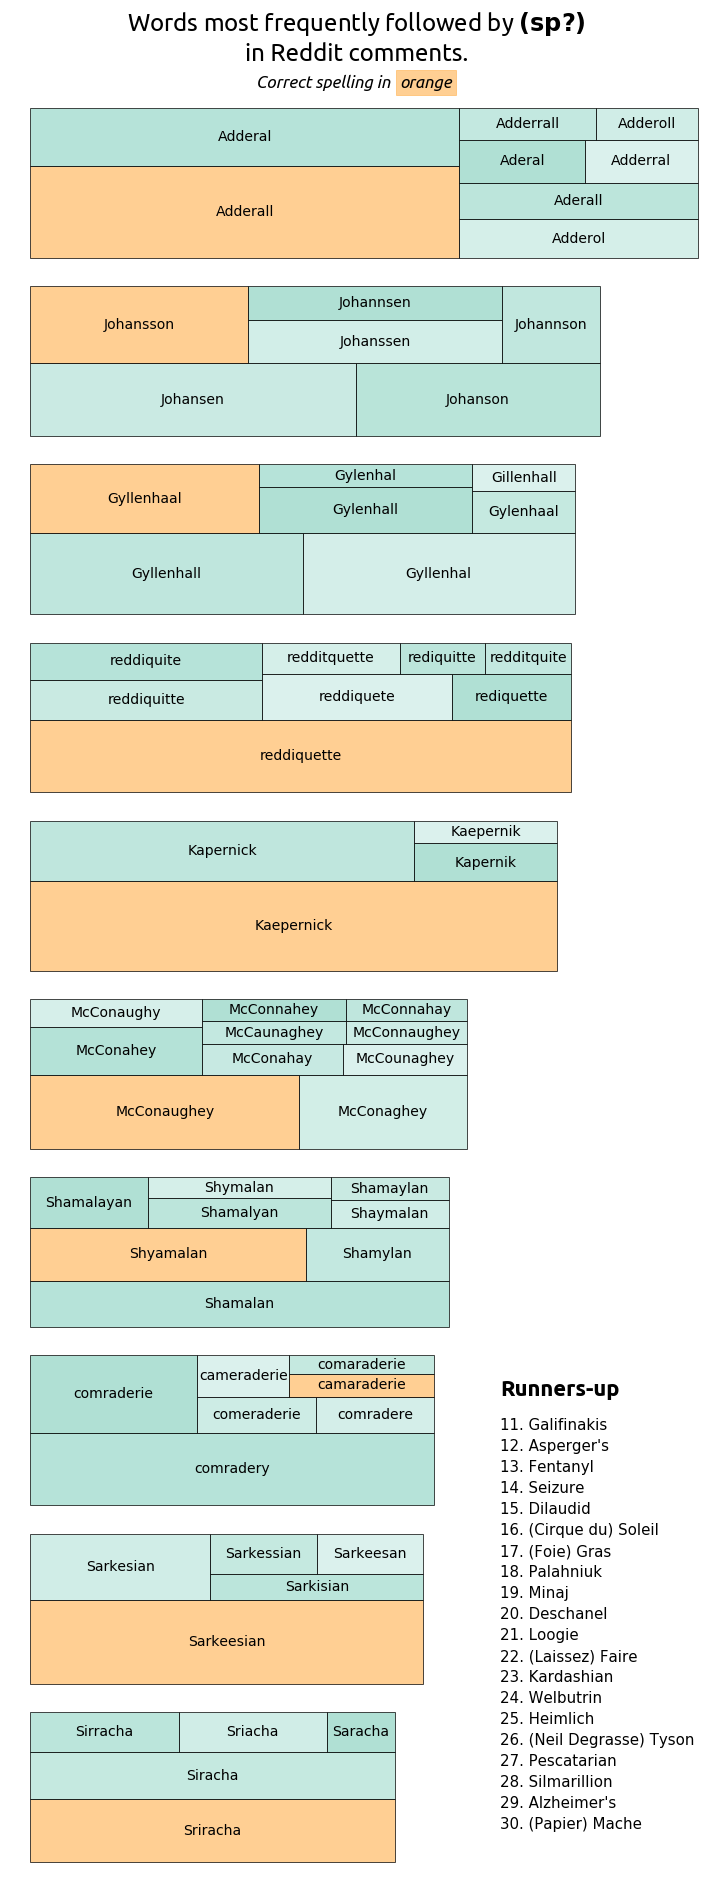

In [32]:
# (Sorry, this cell is a big ol' mess)
import numpy as np
import matplotlib.cm
import random

# Various colormaps experimented w/
cm_name = 'Pastel1'
cm_name = 'Set3'
cm_name = 'Wistia'
cm_name='cool'
cm_name = 'Pastel2'
cm_name = 'BuGn'
cm_endpoint = .4
cm_start = .25

correct_color = '#ffbb66'

random.seed(1)

def fmt_word_form(form):
    if form == 'adderall' and False: # nvm, too busy, not important
        return 'Adderall\n' +  r"($\it{n=73}$)"
    if form.startswith('mcc'):
        return 'McC' + form[3:]
    elif form[0] == 'c' or form.startswith('red'): # comrady, rediquet
        return form
    else:
        return form.capitalize()

def plot_cluster(cluster, ax, rel_size, base_color, correct):
    items = sorted(cluster.items(), key=lambda tup:tup[1], reverse=True)
    forms, counts = zip(*items)
    labels = list(map(fmt_word_form, forms))
    canon = forms[0]
    base_x = base_y = 1
    cm = matplotlib.cm.get_cmap(cm_name)
    n = len(cluster)
    if n > cm.N:
        print("Not enough colors for {}!".format(canon))
    try:
        color = list(cm.colors[:n])
    except AttributeError: # Continuous cmap
        color = [cm(cm_start + i * ((cm_endpoint-cm_start)/(n-1)) ) for i in range(n)]
    random.shuffle(color)
    
    correct_ix = forms.index(correct)
    color[correct_ix] = correct_color
    squarifyplot(
        sizes=counts,
        label=labels,
        alpha=.7,
        ax=ax,
        norm_x=rel_size * base_x,
        norm_y=base_y,
        color=color,
        edgecolor='black',
        labelsize=14,
        lw=1,
        clip_on=False,
        #labelfont='Ubuntu',
    )
    # Necessary so that subplots have size proprtional to their total counts
    ax.set_xlim(0, base_x)

# Used for orange 'correct' annotations. I had to google all of these.
corrects = [
    'adderall',
    'johansson',
    'gyllenhaal',
    'reddiquette',
    'kaepernick',
    'mcconaughey',
    'shyamalan',
    'camaraderie',
    'sarkeesian',
    'sriracha',
]
    
def plot_top_n(n):
    cols = 1
    rows = n
    w = 10
    h = 2.7 * n + 1
    fig, axes = plt.subplots(rows, cols, figsize=(w,h))
    fig.set_facecolor('white')
    top_clusters = sorted(clusters.items(), key=lambda tup: sum(tup[1].values()), reverse=True)[:n]
    topsum = sum(top_clusters[0][1].values())
    
    # Abandoned idea of giving each subplot a colormap based on a different tone
    meta_cm = matplotlib.cm.get_cmap('gist_rainbow' and 'gist_earth', n)
    meta_palette = meta_cm(np.linspace(0, .8, n))
    
    for ax, (canon, cluster), base_color, correct in zip(axes[::], top_clusters, meta_palette, corrects):
        total = sum(cluster.values())
        # Get rid of tick marks etc.
        ax.axis('off')
        plot_cluster(cluster, ax, total/topsum, base_color, correct)
        
    return fig, axes

fig, axes = plot_top_n(10)

# Adding bric-a-brac
fn = 'FreeSerif'
fn = 'Laksaman'
fn = 'Ubuntu'
title_y = .97
subplot_y = .82
title = "Words most frequently followed by " + r"$\bf{(sp?)}$" + "\nin Reddit comments."
fig.suptitle(title, y=title_y, fontsize=24, 
             #fontweight='bold', 
             fontname=fn,
            )
sub = "Correct spelling in"
sub_y = .93
sub_kwargs = dict(
    fontsize=17,
    style='italic',
    fontname=fn,
)
fig.text(.36, sub_y, sub, **sub_kwargs)
fig.text(.56, sub_y, "orange", bbox=dict(color=correct_color, alpha=.7), **sub_kwargs)

canon_to_total = {k: sum(v.values()) for k, v in clusters.items()}
ranked = sorted(canon_to_total.items(), key=lambda tup: tup[1], reverse=True)
runnerups = [ (a if a[0]=='(' else a.capitalize()) for a, b in 
    [
 ('galifinakis', 98),
 ('asperger\'s', 98), # top spelling = "asbergers"
 ('fentanyl', 96),
 ('seizure', 84),
 ('dilaudid', 74),
 ('(Cirque du) Soleil', 73),
 ('(Foie) Gras', 71),
 ('palahniuk', 70),
 ('minaj', 69),
 ('deschanel', 69),
 ('loogie', 66),
 ('(Laissez) Faire', 58),
 ('kardashian', 58),
 ('welbutrin', 57),
 ('heimlich', 54),
 ('(Neil Degrasse) Tyson', 51),
 ('pescatarian', 51),
 ('silmarillion', 50),
 ('alzheimer\'s', 50), # top spelling lacks apostrophe
 ('(Papier) Mache', 36)]
            ]
list_txt = ''
for i, form in enumerate(runnerups):
    list_txt += '{}. {}\n'.format(i+11, form)
fig.text(.7, .29, 'Runners-up', fontsize=22, va='top', fontname='Ubuntu',
         fontweight='bold',
        )
fig.text(.7, .27, list_txt[:-1], fontsize=15, va='top',
         linespacing=1.5,
        )

fig.tight_layout();
subplot_y = .92
plt.subplots_adjust(top=subplot_y, bottom=.05)

"""TODOS
x font size adjustment
x text rotation? (actually seems not necessary with current layout)
x bold / highlight correct form (or special color?)
x adjust total area according to n instances (i.e. same scale across treemaps)
x fix color schemes (don't repeat colours within treemap. Use different maps per form?)
x adjust capitalization
x add figure title
x bottom border not showing :/
x add legend/label for orange
x what about putting next 20 as a text list in the right gutter?
x scale (nvm)
x font experiment?
""";

In [5]:
canon_to_total = {k: sum(v.values()) for k, v in clusters.items()}
ranked = sorted(canon_to_total.items(), key=lambda tup: tup[1], reverse=True)
ranked[10:30]

[('galifinakis', 98),
 ('fentanyl', 96),
 ('asbergers', 91),
 ('seizure', 84),
 ('dilaudid', 74),
 ('soleil', 73),
 ('gras', 71),
 ('palahniuk', 70),
 ('deschanel', 69),
 ('minaj', 69),
 ('loogie', 66),
 ('kardashian', 58),
 ('faire', 58),
 ('welbutrin', 57),
 ('heimlich', 54),
 ('pescatarian', 51),
 ('tyson', 51),
 ('silmarillion', 50),
 ('alzheimers', 42),
 ('mache', 36)]